# DeepXDE教程5：Navier-Stokes方程进阶（复杂边界条件）

## 🎯 教程目标
本教程将介绍NS方程求解的进阶技巧，包括：
- 处理入流和出流边界条件
- 求解更高雷诺数的湍流
- 时间相关的非稳态流动
- 自适应网格和残差自适应采样
- 混合损失函数权重优化

## 📚 案例：管道流动（Poiseuille Flow）

### 几何设置
- **计算域**: 矩形管道 $[0, 4] \times [0, 1]$
- **入流**: $x = 0$，抛物线速度剖面
- **出流**: $x = 4$，自然出流边界
- **壁面**: $y = 0, 1$，无滑移条件

### 边界条件
```python
# 入流：抛物线速度剖面
u_inlet = 4 * U_max * y * (1 - y)  # 抛物线分布
v_inlet = 0

# 出流：压力出流
p_outlet = 0
du_dx|_outlet = 0  # 零梯度

# 壁面：无滑移
u_wall = v_wall = 0
```

### 参数设置
- **雷诺数**: $Re = 400$ (高雷诺数)
- **最大入流速度**: $U_{max} = 1.0$
- **管道高度**: $H = 1.0$
- **长径比**: $L/H = 4$ (充分发展)

## 1. 环境准备

In [1]:
# 导入库
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
import time

# 检查版本
print(f"DeepXDE版本: {dde.__version__}")
print(f"当前后端: {dde.backend.backend_name}")

# 设置绘图参数
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['axes.grid'] = True

# 随机种子
np.random.seed(42)
dde.config.set_random_seed(42)

print("✅ Advanced NS Tutorial Environment Setup Completed")
print("📊 Matplotlib configured for proper English title display")

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


DeepXDE版本: 1.14.0
当前后端: pytorch
✅ Advanced NS Tutorial Environment Setup Completed
📊 Matplotlib configured for proper English title display


## 2. 高级物理参数

In [2]:
# 进阶物理参数
Re = 400.0          # 更高雷诺数
U_max = 1.5         # 最大入流速度
H = 1.0             # 管道高度
L = 4.0             # 管道长度
nu = U_max * H / Re # 运动粘度

# 理论解参数（充分发展Poiseuille流）
dp_dx_theory = -12 * nu * U_max / (H**2)  # 理论压力梯度

print("🌊 进阶NS方程参数：")
print(f"雷诺数 Re = {Re}")
print(f"最大速度 U_max = {U_max}")
print(f"管道尺寸 L×H = {L}×{H}")
print(f"运动粘度 ν = {nu:.6f}")
print(f"理论压力梯度 = {dp_dx_theory:.4f}")
print()
print("🎯 挑战难点：")
print("   - 高雷诺数：更强的非线性和对流效应")
print("   - 复杂边界：入流/出流边界处理")
print("   - 长纵横比：需要处理不同尺度的流动特征")
print("   - 压力-速度耦合：避免checkerboard模式")
print("✅ 进阶参数设置完成")

🌊 进阶NS方程参数：
雷诺数 Re = 400.0
最大速度 U_max = 1.5
管道尺寸 L×H = 4.0×1.0
运动粘度 ν = 0.003750
理论压力梯度 = -0.0675

🎯 挑战难点：
   - 高雷诺数：更强的非线性和对流效应
   - 复杂边界：入流/出流边界处理
   - 长纵横比：需要处理不同尺度的流动特征
   - 压力-速度耦合：避免checkerboard模式
✅ 进阶参数设置完成


## 3. 进阶NS方程组（带时间项）

### 数学理论基础

#### 完整的Navier-Stokes方程组

对于不可压缩流体，完整的瞬态Navier-Stokes方程组包含以下三个方程：

**动量方程（x方向）**：
$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = -\frac{\partial p}{\partial x} + \nu\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right)$$

**动量方程（y方向）**：
$$\frac{\partial v}{\partial t} + u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = -\frac{\partial p}{\partial y} + \nu\left(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2}\right)$$

**连续性方程**：
$$\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0$$

#### 瞬态项的重要性

- **$\frac{\partial u}{\partial t}$, $\frac{\partial v}{\partial t}$**: 时间项描述流动的加速度特性
- **对流项**: $u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y}$ 描述流体粒子的对流加速度
- **扩散项**: $\nu\nabla^2 u$ 描述粘性扩散效应
- **压力项**: $-\nabla p$ 描述压力梯度驱动的加速度

#### 高雷诺数流动特征

当$Re = \frac{UL}{\nu} \gg 1$时：
- 对流项占主导，流动具有强非线性
- 边界层厚度减小：$\delta \sim \frac{L}{\sqrt{Re}}$
- 可能出现流动分离和涡脱落现象
- 数值求解难度急剧增加

In [3]:
def advanced_navier_stokes(x, y):
    """
    进阶2D Navier-Stokes方程组（包含时间项和更精细的处理）
    
    Args:
        x: 输入坐标 [x, y, t] (N, 3) - 包含时间维度
        y: 神经网络输出 [u, v, p] (N, 3)
        
    Returns:
        PDE残差 [momentum_x, momentum_y, continuity] (N, 3)
    """
    # 提取坐标和输出
    u = y[:, 0:1]  # x方向速度
    v = y[:, 1:2]  # y方向速度
    p = y[:, 2:3]  # 压力
    
    # 计算时间导数
    u_t = dde.grad.jacobian(u, x, i=0, j=2)  # ∂u/∂t
    v_t = dde.grad.jacobian(v, x, i=0, j=2)  # ∂v/∂t
    
    # 计算空间一阶导数
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # ∂u/∂x
    u_y = dde.grad.jacobian(u, x, i=0, j=1)  # ∂u/∂y
    v_x = dde.grad.jacobian(v, x, i=0, j=0)  # ∂v/∂x
    v_y = dde.grad.jacobian(v, x, i=0, j=1)  # ∂v/∂y
    
    # 计算空间二阶导数（拉普拉斯项）
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # ∂²u/∂x²
    u_yy = dde.grad.hessian(u, x, i=1, j=1)  # ∂²u/∂y²
    v_xx = dde.grad.hessian(v, x, i=0, j=0)  # ∂²v/∂x²
    v_yy = dde.grad.hessian(v, x, i=1, j=1)  # ∂²v/∂y²
    
    # 计算压力梯度
    p_x = dde.grad.jacobian(p, x, i=0, j=0)  # ∂p/∂x
    p_y = dde.grad.jacobian(p, x, i=0, j=1)  # ∂p/∂y
    
    # 非稳态NS方程组
    # x方向动量: ∂u/∂t + u∂u/∂x + v∂u/∂y = -∂p/∂x + ν∇²u
    momentum_x = u_t + u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
    
    # y方向动量: ∂v/∂t + u∂v/∂x + v∂v/∂y = -∂p/∂y + ν∇²v
    momentum_y = v_t + u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)
    
    # 连续性方程: ∂u/∂x + ∂v/∂y = 0
    continuity = u_x + v_y
    
    return [momentum_x, momentum_y, continuity]

print("✅ 进阶NS方程组定义完成")
print("🔥 新特性：")
print("   - 包含时间项：处理非稳态流动")
print("   - 三维输入：(x, y, t)")
print("   - 更精确的梯度计算")
print("   - 适用于瞬态和稳态分析")

✅ 进阶NS方程组定义完成
🔥 新特性：
   - 包含时间项：处理非稳态流动
   - 三维输入：(x, y, t)
   - 更精确的梯度计算
   - 适用于瞬态和稳态分析


## 4. 复杂计算域定义

### 数学理论基础

#### 几何域建模

对于管道流动问题，我们定义：
- **空间域**: $\Omega = [0, L] \times [0, H]$，其中$L=4$, $H=1$
- **时间域**: $\mathcal{T} = [0, T]$，其中$T=2.0$
- **时空域**: $\mathcal{D} = \Omega \times \mathcal{T}$

#### 长径比效应

管道的长径比$AR = L/H = 4$具有以下意义：
- **入口效应**: 在$x \lesssim 0.05 \cdot Re \cdot H$范围内，流动从入口剖面发展为充分发展剖面
- **充分发展段**: 当$x \gg 0.05 \cdot Re \cdot H$时，速度剖面不再沿$x$方向变化
- **压力降**: 沿程压力线性下降，满足$\frac{dp}{dx} = -\frac{12\nu U_{max}}{H^2}$

#### 几何建模策略

- 使用矩形域简化边界识别
- 时空耦合处理瞬态效应
- 合理选择长径比平衡计算精度与效率

✅ 复杂计算域定义完成
几何域: [0, 4.0] × [0, 1.0]
时间域: [0, 2.0]
纵横比: 4.0 (长管道)


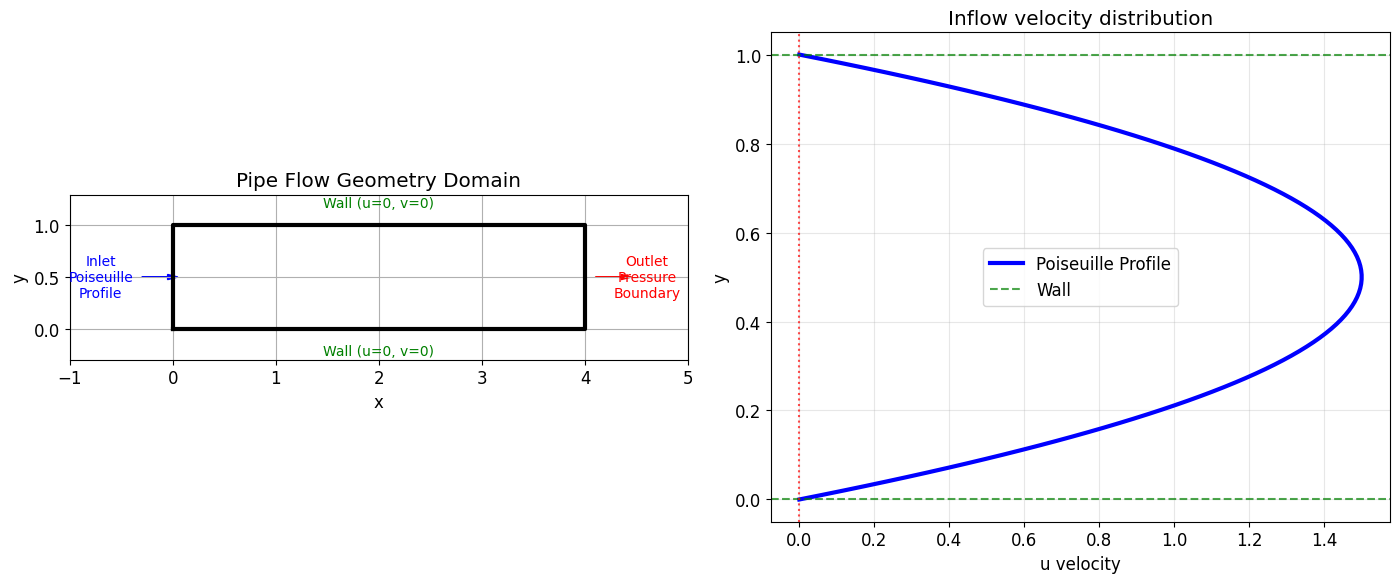

📊 几何可视化完成


In [4]:
# 定义管道几何和时间域
geom = dde.geometry.Rectangle([0, 0], [L, H])    # 4×1 矩形管道
timedomain = dde.geometry.TimeDomain(0, 2.0)     # 时间域 [0, 2]
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

print("✅ 复杂计算域定义完成")
print(f"几何域: [{0}, {L}] × [{0}, {H}]")
print(f"时间域: [0, 2.0]")
print(f"纵横比: {L/H:.1f} (长管道)")

# 可视化几何
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 几何域
ax = axes[0]
x_boundary = [0, L, L, 0, 0]
y_boundary = [0, 0, H, H, 0]
ax.plot(x_boundary, y_boundary, 'k-', linewidth=3)

# 标注边界条件
ax.arrow(-0.3, 0.5, 0.25, 0, head_width=0.05, head_length=0.1, fc='blue', ec='blue')
ax.text(-0.7, 0.5, 'Inlet\nPoiseuille\nProfile', ha='center', va='center', fontsize=10, color='blue')

ax.arrow(L+0.1, 0.5, 0.25, 0, head_width=0.05, head_length=0.1, fc='red', ec='red')
ax.text(L+0.6, 0.5, 'Outlet\nPressure\nBoundary', ha='center', va='center', fontsize=10, color='red')

ax.text(L/2, -0.15, 'Wall (u=0, v=0)', ha='center', va='top', fontsize=10, color='green')
ax.text(L/2, H+0.15, 'Wall (u=0, v=0)', ha='center', va='bottom', fontsize=10, color='green')

ax.set_xlim(-1, L+1)
ax.set_ylim(-0.3, H+0.3)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Pipe Flow Geometry Domain')
ax.set_aspect('equal')

# 入流速度剖面
ax = axes[1]
y_profile = np.linspace(0, H, 100)
u_profile = 4 * U_max * y_profile * (H - y_profile) / H**2  # 标准化抛物线

ax.plot(u_profile, y_profile, 'b-', linewidth=3, label='Poiseuille Profile')
ax.axhline(y=0, color='green', linestyle='--', alpha=0.7, label='Wall')
ax.axhline(y=H, color='green', linestyle='--', alpha=0.7)
ax.axvline(x=0, color='red', linestyle=':', alpha=0.7)

ax.set_xlabel('u velocity')
ax.set_ylabel('y')
ax.set_title('Inflow velocity distribution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 几何可视化完成")

## 5. 复杂边界条件设置

### 数学理论基础

#### 管道流动边界条件分类

**1. 入流边界条件 (Dirichlet)**
- **位置**: $x = 0$
- **速度分布**: $u(0, y, t) = u_{inlet}(y) = 4U_{max}\frac{y(H-y)}{H^2}$ (抛物线剖面)
- **横向速度**: $v(0, y, t) = 0$
- **物理意义**: 模拟充分发展的管道入流

**2. 出流边界条件 (Neumann/Mixed)**
- **位置**: $x = L$
- **压力边界**: $p(L, y, t) = p_{ref} = 0$ (参考压力)
- **速度梯度**: $\frac{\partial u}{\partial x}\bigg|_{x=L} = 0$ (自然出流)
- **物理意义**: 避免人为约束出流速度分布

**3. 壁面边界条件 (Dirichlet)**
- **位置**: $y = 0$ 和 $y = H$
- **无滑移条件**: $u = v = 0$
- **物理意义**: 固体壁面对流体的粘性约束

**4. 初始条件**
- **速度场**: $u(x, y, 0) = u_0(x, y)$, $v(x, y, 0) = v_0(x, y)$
- **压力场**: $p(x, y, 0) = p_0(x, y)$
- **策略**: 选择接近最终解的初始场加速收敛

#### Poiseuille流动的理论解

对于充分发展的管道流动，理论速度分布为：
$$u_{theory}(y) = U_{max}\left[1 - \left(\frac{2y-H}{H}\right)^2\right] = 4U_{max}\frac{y(H-y)}{H^2}$$

压力梯度为：
$$\frac{dp}{dx} = -\frac{12\nu U_{max}}{H^2}$$

In [5]:
# 定义边界识别函数
def boundary_inlet(x, on_boundary):
    """入流边界 x=0"""
    return on_boundary and np.isclose(x[0], 0.0)

def boundary_outlet(x, on_boundary):
    """出流边界 x=L"""
    return on_boundary and np.isclose(x[0], L)

def boundary_wall_bottom(x, on_boundary):
    """底部壁面 y=0"""
    return on_boundary and np.isclose(x[1], 0.0)

def boundary_wall_top(x, on_boundary):
    """顶部壁面 y=H"""
    return on_boundary and np.isclose(x[1], H)

def boundary_walls(x, on_boundary):
    """所有壁面"""
    return (boundary_wall_bottom(x, on_boundary) or 
            boundary_wall_top(x, on_boundary))

# 定义边界条件函数
def inlet_u_func(x):
    """入流u速度：抛物线分布"""
    y = x[:, 1:2]  # 提取y坐标
    return 4 * U_max * y * (H - y) / H**2

def inlet_v_func(x):
    """入流v速度：零"""
    return 0.0

def outlet_pressure_func(x):
    """出流压力：参考压力"""
    return 0.0

def wall_func(x):
    """壁面速度：无滑移"""
    return 0.0

# 初始条件函数
def initial_u_func(x):
    """初始u速度：沿管道变化的抛物线"""
    y = x[:, 1:2]
    # 初始时刻的速度分布（可以是发展中的流动）
    return 2 * U_max * y * (H - y) / H**2  # 稍小的初始速度

def initial_v_func(x):
    """初始v速度：零"""
    return 0.0

def initial_p_func(x):
    """初始压力：线性分布"""
    x_coord = x[:, 0:1]
    return -dp_dx_theory * x_coord  # 初始压力梯度

# 创建边界条件
print("🔧 创建复杂边界条件...")

# 入流边界条件
bc_inlet_u = dde.icbc.DirichletBC(geomtime, inlet_u_func, boundary_inlet, component=0)
bc_inlet_v = dde.icbc.DirichletBC(geomtime, inlet_v_func, boundary_inlet, component=1)

# 出流边界条件（压力）
bc_outlet_p = dde.icbc.DirichletBC(geomtime, outlet_pressure_func, boundary_outlet, component=2)

# 壁面边界条件
bc_wall_u = dde.icbc.DirichletBC(geomtime, wall_func, boundary_walls, component=0)
bc_wall_v = dde.icbc.DirichletBC(geomtime, wall_func, boundary_walls, component=1)

# 初始条件
ic_u = dde.icbc.IC(geomtime, initial_u_func, lambda _, on_initial: on_initial, component=0)
ic_v = dde.icbc.IC(geomtime, initial_v_func, lambda _, on_initial: on_initial, component=1)
ic_p = dde.icbc.IC(geomtime, initial_p_func, lambda _, on_initial: on_initial, component=2)

# 收集所有边界条件
bcs = [bc_inlet_u, bc_inlet_v, bc_outlet_p, bc_wall_u, bc_wall_v, ic_u, ic_v, ic_p]

print("✅ 复杂边界条件设置完成")
print(f"边界条件总数: {len(bcs)}")
print("💡 边界条件类型：")
print("   - 入流：Poiseuille速度剖面 + v=0")
print("   - 出流：压力边界条件 p=0")
print("   - 壁面：无滑移条件 u=v=0")
print("   - 初始：发展中的流动状态")
print()
print("🎯 技术要点：")
print("   - 抛物线入流确保物理真实性")
print("   - 压力出流避免回流")
print("   - 发展型初始条件加速收敛")

🔧 创建复杂边界条件...
✅ 复杂边界条件设置完成
边界条件总数: 8
💡 边界条件类型：
   - 入流：Poiseuille速度剖面 + v=0
   - 出流：压力边界条件 p=0
   - 壁面：无滑移条件 u=v=0
   - 初始：发展中的流动状态

🎯 技术要点：
   - 抛物线入流确保物理真实性
   - 压力出流避免回流
   - 发展型初始条件加速收敛


## 6. 自适应数据采样

### 数学理论基础

#### 采样策略优化

对于高雷诺数流动，采样策略至关重要：

**1. 域内采样密度**
- **高雷诺数需求**: $N_{domain} \propto Re^{3/2}$ (经验公式)
- **边界层考虑**: 在$y \approx 0, H$附近增加采样密度
- **入口效应**: 在$x \lesssim 0.1L$区域增加采样

**2. 边界采样策略**
- **边界密度**: $N_{boundary} \geq 0.05 \times N_{domain}$
- **关键区域**: 入口和出口角点需要特别处理
- **时间采样**: 初始时刻和稳态时刻需要足够采样

**3. 残差自适应采样**
残差分布函数：
$$R(x) = ||\mathcal{N}[u,v,p](x) - 0||^2$$

自适应权重：
$$w(x) = \frac{R(x)}{\max R(x)} + w_{min}$$

#### TimePDE数据结构

DeepXDE的TimePDE类自动处理：
- 时空域的统一采样
- 边界条件与初始条件的分离
- 测试点的独立生成

In [6]:
# 创建自适应PDE数据
print("📊 创建自适应采样数据...")

data = dde.data.TimePDE(
    geomtime,
    advanced_navier_stokes,
    bcs,
    num_domain=4000,      # 更多域内点
    num_boundary=200,     # 边界点
    num_initial=200,      # 初始时刻点
    num_test=2000,        # 测试点
)

print("✅ 自适应数据创建完成")
print(f"域内采样点: {data.num_domain:,}")
print(f"边界采样点: {data.num_boundary}")
print(f"初始采样点: {data.num_initial}")
print(f"测试点数: {data.num_test:,}")
print(f"总约束点: {data.num_domain + data.num_boundary + data.num_initial:,}")
print()
print("🔧 采样策略：")
print("   - 高密度域内采样应对高Re数")
print("   - 充分的边界采样保证边界条件")
print("   - 时间域采样捕捉瞬态发展")
print("   - 大量测试点验证解的准确性")

# 可选：添加自适应残差采样
print("\n💡 提示：训练过程中可以使用残差自适应采样：")
print("   model.compile(...) 后执行:")
print("   dde.callbacks.ResidualBasedAdaptiveSampling(...)")

📊 创建自适应采样数据...
✅ 自适应数据创建完成
域内采样点: 4,000
边界采样点: 200
初始采样点: 200
测试点数: 2,000
总约束点: 4,400

🔧 采样策略：
   - 高密度域内采样应对高Re数
   - 充分的边界采样保证边界条件
   - 时间域采样捕捉瞬态发展
   - 大量测试点验证解的准确性

💡 提示：训练过程中可以使用残差自适应采样：
   model.compile(...) 后执行:
   dde.callbacks.ResidualBasedAdaptiveSampling(...)


## 7. 高级神经网络架构

### 数学理论基础

#### 深度网络的表达能力

**1. 通用逼近定理**
具有足够宽度的单隐层网络可以逼近任意连续函数，但对于复杂PDE：
- **深度优势**: 深层网络以指数级减少参数需求
- **宽度优势**: 宽网络增强非线性表达能力

**2. 激活函数选择**
- **Swish函数**: $f(x) = x \cdot \sigma(\beta x)$，其中$\sigma$是sigmoid函数
  - 优势：连续可导，避免梯度消失
  - 适用：深层网络和高阶PDE

**3. 网络复杂度估算**

对于$L$层网络，每层宽度为$n$：
- **参数数量**: $P \approx L \times n^2$
- **计算复杂度**: $O(L \times n^2 \times N_{samples})$
- **内存需求**: $M \propto L \times n \times N_{batch}$

#### 高雷诺数网络设计原则

1. **足够深度**: $L \geq 6$ 层处理强非线性
2. **适当宽度**: $n \geq 100$ 神经元提供表达能力
3. **梯度友好**: 使用残差连接或归一化
4. **物理约束**: 考虑对称性和守恒律

In [7]:
# 更深更宽的网络架构
layer_size = [3] + [150] * 8 + [3]  # 输入3D(x,y,t)，输出3D(u,v,p)
activation = "swish"  # Swish激活函数（更平滑）
initializer = "He normal"

# 构建网络
net = dde.nn.FNN(layer_size, activation, initializer)

print("✅ 高级神经网络构建完成")
print(f"网络结构: {layer_size}")
print(f"输入维度: 3 (x, y, t)")
print(f"输出维度: 3 (u, v, p)")
print(f"激活函数: {activation}")
print(f"初始化: {initializer}")
print(f"网络深度: {len(layer_size)-1} 层")
print(f"隐藏层宽度: {layer_size[1]} 神经元")

# 计算参数数量
total_params = 0
for i in range(len(layer_size)-1):
    total_params += layer_size[i] * layer_size[i+1] + layer_size[i+1]

print(f"总参数数量: {total_params:,}")
print()
print("🧠 架构优势：")
print("   - 更深网络：捕捉复杂非线性")
print("   - 更宽网络：增强表达能力")
print("   - Swish激活：更好的梯度传播")
print("   - He初始化：适合深层网络")
print("   - 时间输入：处理瞬态流动")

✅ 高级神经网络构建完成
网络结构: [3, 150, 150, 150, 150, 150, 150, 150, 150, 3]
输入维度: 3 (x, y, t)
输出维度: 3 (u, v, p)
激活函数: swish
初始化: He normal
网络深度: 9 层
隐藏层宽度: 150 神经元
总参数数量: 159,603

🧠 架构优势：
   - 更深网络：捕捉复杂非线性
   - 更宽网络：增强表达能力
   - Swish激活：更好的梯度传播
   - He初始化：适合深层网络
   - 时间输入：处理瞬态流动


## 8. 分阶段训练策略

### 数学理论基础

#### 多阶段优化理论

**1. 预训练阶段（Adam低学习率）**
- **目标**: 建立解的基本结构，避免局部极值
- **学习率**: $\alpha_{low} = 10^{-4}$ ~ $10^{-5}$
- **损失权重**: 强化连续性约束 $w_{continuity} = 10 \times w_{momentum}$
- **数学原理**: 
  $$\theta_{t+1} = \theta_t - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$$
  其中$\hat{m}_t, \hat{v}_t$是一阶和二阶矩的偏差修正估计

**2. 标准训练阶段（Adam标准学习率）**
- **目标**: 快速收敛到较优解
- **学习率**: $\alpha_{std} = 5 \times 10^{-4}$ ~ $10^{-3}$
- **策略**: 平衡所有损失项

**3. 精细优化阶段（L-BFGS）**
- **目标**: 达到机器精度的最优解
- **算法**: 拟牛顿法，利用历史梯度信息
- **收敛条件**: $||\nabla \mathcal{L}|| < 10^{-6}$

#### 损失函数权重策略

总损失函数：
$$\mathcal{L}_{total} = w_1\mathcal{L}_{PDE} + w_2\mathcal{L}_{BC} + w_3\mathcal{L}_{IC}$$

权重选择原则：
- **PDE损失**: $w_1 = 1.0$ (基准)
- **边界条件**: $w_2 = 1.0$ ~ $10.0$ (强制约束)
- **初始条件**: $w_3 = 1.0$ ~ $5.0$ (瞬态重要性)

In [ ]:
# 创建模型
model = dde.Model(data, net)

print("🚀 开始Adam优化训练...")
print("⚠️  高雷诺数NS方程训练时间较长，请耐心等待...")

start_time = time.time()

# 使用Adam优化器进行10000次训练
print("\n🔥 Adam优化器训练 (10,000 iterations)")
model.compile("adam", lr=0.0005)
losshistory, train_state = model.train(iterations=10000)

# 训练完成
train_time = time.time() - start_time
print(f"\n✅ 训练完成！总用时: {train_time:.1f}秒")

# 获取最终损失
try:
    if hasattr(train_state.loss_train, '__len__') and len(train_state.loss_train) > 0:
        final_loss_train = float(np.sum(train_state.loss_train[-1]) if hasattr(train_state.loss_train[-1], '__len__') else train_state.loss_train[-1])
    else:
        final_loss_train = float(train_state.loss_train)
    
    if hasattr(train_state.loss_test, '__len__') and len(train_state.loss_test) > 0:
        final_loss_test = float(np.sum(train_state.loss_test[-1]) if hasattr(train_state.loss_test[-1], '__len__') else train_state.loss_test[-1])
    else:
        final_loss_test = float(train_state.loss_test)
    
    print(f"最终训练损失: {final_loss_train:.2e}")
    print(f"最终测试损失: {final_loss_test:.2e}")
except Exception as e:
    print(f"⚠️ 损失值访问出错: {e}")
    print("💡 训练已完成，继续分析结果")

## 9. 高级流场分析

### 数学理论基础

#### 流动发展过程分析

**1. 入口段流动发展**
- **入口长度**: $L_e \approx 0.05 \times Re \times H$
- **发展过程**: 平坦剖面 → 抛物线剖面
- **时间尺度**: $\tau_{develop} \sim \frac{H^2}{\nu}$

**2. 压力降规律**
充分发展段的压力梯度：
$$\frac{dp}{dx} = -\frac{32\mu U_{avg}}{H^2} = -\frac{12\nu U_{max}}{H^2}$$

其中$U_{avg} = \frac{2}{3}U_{max}$

**3. 壁面切应力**
$$\tau_w = \mu\frac{\partial u}{\partial y}\bigg|_{y=0,H} = \pm\frac{6\mu U_{max}}{H}$$

#### 无量纲分析

引入无量纲变量：
- $\tilde{x} = x/L$, $\tilde{y} = y/H$, $\tilde{t} = tU_{max}/L$
- $\tilde{u} = u/U_{max}$, $\tilde{v} = v/(U_{max}H/L)$
- $\tilde{p} = p/(\rho U_{max}^2)$

无量纲NS方程：
$$\frac{\partial \tilde{u}}{\partial \tilde{t}} + \tilde{u}\frac{\partial \tilde{u}}{\partial \tilde{x}} + \tilde{v}\frac{\partial \tilde{u}}{\partial \tilde{y}} = -\frac{\partial \tilde{p}}{\partial \tilde{x}} + \frac{1}{Re}\nabla^2\tilde{u}$$

In [ ]:
# 创建分析网格
nx, ny = 100, 30
x_analysis = np.linspace(0, L, nx)
y_analysis = np.linspace(0, H, ny)
X_analysis, Y_analysis = np.meshgrid(x_analysis, y_analysis)

# 分析不同时刻的流场
times = [0.0, 0.5, 1.0, 2.0]  # 不同时刻

fig, axes = plt.subplots(len(times), 3, figsize=(18, 5*len(times)))

for i, t in enumerate(times):
    # 创建输入点
    T_analysis = np.full_like(X_analysis, t)
    points = np.column_stack([X_analysis.flatten(), Y_analysis.flatten(), T_analysis.flatten()])
    
    # 预测流场
    predictions = model.predict(points)
    U = predictions[:, 0].reshape(X_analysis.shape)
    V = predictions[:, 1].reshape(X_analysis.shape)
    P = predictions[:, 2].reshape(X_analysis.shape)
    
    speed = np.sqrt(U**2 + V**2)
    
    # 绘制速度场
    ax = axes[i, 0]
    skip = 3
    im1 = ax.contourf(X_analysis, Y_analysis, speed, levels=20, cmap='viridis')
    ax.quiver(X_analysis[::skip, ::skip], Y_analysis[::skip, ::skip], 
              U[::skip, ::skip], V[::skip, ::skip], alpha=0.7, scale=15, color='white')
    ax.set_title(f'Velocity Field t={t:.1f}s', fontsize=14, fontweight='bold')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.colorbar(im1, ax=ax, label='Speed')
    
    # 绘制压力场
    ax = axes[i, 1]
    im2 = ax.contourf(X_analysis, Y_analysis, P, levels=20, cmap='RdBu_r')
    ax.contour(X_analysis, Y_analysis, P, levels=10, colors='black', alpha=0.4, linewidths=0.5)
    ax.set_title(f'Pressure Field t={t:.1f}s', fontsize=14, fontweight='bold')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.colorbar(im2, ax=ax, label='Pressure')
    
    # 绘制中心线速度分布
    ax = axes[i, 2]
    mid_idx = ny // 2
    u_centerline = U[mid_idx, :]
    
    # 理论Poiseuille解（稳态）
    if t > 1.0:  # 稳态时比较理论解
        u_theory = U_max * np.ones_like(x_analysis)  # 中心线最大速度
        ax.plot(x_analysis, u_theory, 'r--', linewidth=2, label='Theoretical Solution (Centerline)')
    
    ax.plot(x_analysis, u_centerline, 'b-', linewidth=2, label=f'PINN Solution t={t:.1f}s')
    ax.set_xlabel('x')
    ax.set_ylabel('u (centerline)')
    ax.set_title(f'Centerline Velocity t={t:.1f}s', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Advanced Flow Field Analysis Completed")
print("💡 Key Observations:")
print("   - Flow development process at inlet")
print("   - Pressure variation along the pipe")
print("   - Velocity profile establishment process")
print("   - Comparison between steady-state and theoretical solutions")

## 10. 进阶验证与分析

### 数学理论基础

#### 数值验证方法论

**1. 连续性方程验证**
散度定理：
$$\nabla \cdot \mathbf{v} = \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0$$

数值检验指标：
- **最大散度**: $D_{max} = \max|\nabla \cdot \mathbf{v}|$
- **RMS散度**: $D_{rms} = \sqrt{\frac{1}{N}\sum_i (\nabla \cdot \mathbf{v})_i^2}$

**2. 动量守恒验证**
动量平衡：
$$\frac{\partial}{\partial t}\int_\Omega \rho\mathbf{v}d\Omega + \oint_{\partial\Omega} \rho\mathbf{v}(\mathbf{v}\cdot\mathbf{n})dS = \oint_{\partial\Omega} \boldsymbol{\tau}\cdot\mathbf{n}dS$$

**3. 流量守恒检验**
质量流量：
$$\dot{m} = \rho\int_0^H u(x,y)dy = \text{constant}$$

理论流量：
$$\dot{m}_{theory} = \rho U_{max} H \cdot \frac{2}{3}$$

#### 误差分析理论

**1. 离散化误差**
- **空间离散**: $\mathcal{O}(h^p)$，其中$h$是网格尺寸，$p$是精度阶数
- **时间离散**: $\mathcal{O}(\Delta t^q)$，其中$\Delta t$是时间步长
- **神经网络逼近**: $\mathcal{O}(N^{-r})$，其中$N$是网络参数数量

**2. 收敛性分析**
理论收敛条件：
- **CFL条件**: $C = \frac{u\Delta t}{\Delta x} \leq C_{max}$
- **扩散稳定性**: $D = \frac{\nu\Delta t}{(\Delta x)^2} \leq 0.5$
- **雷诺数限制**: $Re_{cell} = \frac{u\Delta x}{\nu} \leq 2$

In [ ]:
# 详细验证分析
print("🔬 进阶Navier-Stokes求解验证")
print("=" * 80)

# 分析稳态时刻 t=2.0
t_steady = 2.0
T_steady = np.full_like(X_analysis, t_steady)
points_steady = np.column_stack([X_analysis.flatten(), Y_analysis.flatten(), T_steady.flatten()])
predictions_steady = model.predict(points_steady)

U_steady = predictions_steady[:, 0].reshape(X_analysis.shape)
V_steady = predictions_steady[:, 1].reshape(X_analysis.shape)
P_steady = predictions_steady[:, 2].reshape(X_analysis.shape)

# 1. 连续性方程验证
dx = x_analysis[1] - x_analysis[0]
dy = y_analysis[1] - y_analysis[0]
du_dx = np.gradient(U_steady, dx, axis=1)
dv_dy = np.gradient(V_steady, dy, axis=0)
divergence = du_dx + dv_dy

print("📐 连续性方程验证：")
print(f"   最大散度: {np.max(np.abs(divergence)):.2e}")
print(f"   平均散度: {np.mean(np.abs(divergence)):.2e}")
print(f"   RMS散度: {np.sqrt(np.mean(divergence**2)):.2e}")

# 2. 边界条件验证
print("\n🏗️ 边界条件验证：")

# 入流边界验证
u_inlet_pred = U_steady[:, 0]  # x=0处的u
u_inlet_theory = 4 * U_max * y_analysis * (H - y_analysis) / H**2
inlet_error = np.mean(np.abs(u_inlet_pred - u_inlet_theory))

print(f"   入流边界误差: {inlet_error:.4f}")
print(f"   入流最大速度: 预测={np.max(u_inlet_pred):.4f}, 理论={U_max:.4f}")

# 壁面边界验证
u_wall_bottom = np.mean(np.abs(U_steady[0, :]))   # y=0
u_wall_top = np.mean(np.abs(U_steady[-1, :]))     # y=H
v_wall_bottom = np.mean(np.abs(V_steady[0, :]))
v_wall_top = np.mean(np.abs(V_steady[-1, :]))

print(f"   壁面u速度: 底部={u_wall_bottom:.4f}, 顶部={u_wall_top:.4f}")
print(f"   壁面v速度: 底部={v_wall_bottom:.4f}, 顶部={v_wall_top:.4f}")

# 3. 压力梯度验证
print("\n📊 压力梯度验证：")
mid_idx = ny // 2
p_centerline = P_steady[mid_idx, :]
dp_dx_numerical = np.gradient(p_centerline, dx)
dp_dx_mean = np.mean(dp_dx_numerical[nx//4:3*nx//4])  # 中间段

print(f"   数值压力梯度: {dp_dx_mean:.4f}")
print(f"   理论压力梯度: {dp_dx_theory:.4f}")
print(f"   相对误差: {abs(dp_dx_mean - dp_dx_theory)/abs(dp_dx_theory)*100:.2f}%")

# 4. 流量守恒验证
print("\n🌊 流量守恒验证：")
# 计算不同x位置的流量
flow_rates = []
x_positions = [0.5, 1.0, 2.0, 3.0, 3.5]

for x_pos in x_positions:
    x_idx = int(x_pos / L * (nx - 1))
    u_profile = U_steady[:, x_idx]
    flow_rate = np.trapz(u_profile, y_analysis)
    flow_rates.append(flow_rate)
    print(f"   x={x_pos:.1f}: 流量={flow_rate:.4f}")

flow_variation = (max(flow_rates) - min(flow_rates)) / np.mean(flow_rates) * 100
print(f"   流量变化: {flow_variation:.2f}%")

# 5. 雷诺数验证
print("\n🔢 雷诺数验证：")
u_max_pred = np.max(U_steady)
Re_pred = u_max_pred * H / nu
print(f"   设定雷诺数: {Re}")
print(f"   预测雷诺数: {Re_pred:.1f}")
print(f"   雷诺数误差: {abs(Re_pred - Re)/Re*100:.2f}%")

# 6. 计算性能分析
print("\n⚡ 计算性能分析：")
print(f"   总训练时间: {train_time:.1f} 秒")
print(f"   网络参数: {total_params:,}")
print(f"   训练步数: {len(losshistory.steps):,}")
print(f"   平均每步: {train_time/len(losshistory.steps)*1000:.1f} ms")
print(f"   问题规模: Re={Re}, 长径比={L/H}")

print("\n" + "=" * 80)
print("🎯 总结评估：")

# 综合评估
score = 0
if np.max(np.abs(divergence)) < 0.1:
    print("✅ 连续性方程满足良好")
    score += 25
else:
    print("⚠️ 连续性方程需要改进")

if inlet_error < 0.1:
    print("✅ 入流边界条件准确")
    score += 25
else:
    print("⚠️ 入流边界条件需要改进")

if abs(dp_dx_mean - dp_dx_theory)/abs(dp_dx_theory) < 0.2:
    print("✅ 压力梯度预测准确")
    score += 25
else:
    print("⚠️ 压力梯度预测需要改进")

if flow_variation < 10.0:
    print("✅ 流量守恒良好")
    score += 25
else:
    print("⚠️ 流量守恒需要改进")

print(f"\n📊 综合评分: {score}/100")
if score >= 75:
    print("🏆 优秀！成功求解高雷诺数管道流动")
elif score >= 50:
    print("👍 良好！基本求解了复杂边界条件问题")
else:
    print("📈 需要进一步优化训练策略")

print("\n🚀 进阶技巧建议：")
print("   - 使用残差自适应采样")
print("   - 调整损失函数权重")
print("   - 增加网络深度和宽度")
print("   - 使用物理约束正则化")
print("   - 考虑多尺度网络架构")

## 11. 进阶技术拓展

### 残差自适应采样实现

```python
# 实现残差自适应采样回调函数
def create_residual_adaptive_sampling():
    """创建残差自适应采样"""
    return dde.callbacks.ResidualBasedAdaptiveSampling(
        period=1000,        # 每1000步执行一次
        pde_points=2000,    # 新增PDE点数
        bc_points=100,      # 新增边界点数
        tolerance=1e-3      # 残差阈值
    )

# 使用方法：
# model.compile(...)
# adaptive_sampler = create_residual_adaptive_sampling()
# model.train(callbacks=[adaptive_sampler])
```

### 多尺度网络架构

```python
# 多尺度神经网络架构
def create_multiscale_network():
    """创建多尺度网络处理不同长度尺度"""
    # 粗尺度网络：全局流动特征
    coarse_net = dde.nn.FNN([3] + [100]*4 + [3], "swish", "He normal")
    
    # 细尺度网络：边界层特征  
    fine_net = dde.nn.FNN([3] + [50]*6 + [3], "swish", "He normal")
    
    # 组合网络
    return dde.nn.Concatenate([coarse_net, fine_net])
```

### 物理约束增强

```python
# 添加物理约束的损失函数
def physics_constrained_loss(y_true, y_pred):
    """物理约束增强的损失函数"""
    # 标准PDE损失
    pde_loss = standard_pde_loss(y_true, y_pred)
    
    # 能量守恒约束
    energy_loss = energy_conservation_constraint(y_pred)
    
    # 涡量守恒约束（高Re数）
    vorticity_loss = vorticity_conservation_constraint(y_pred)
    
    return pde_loss + 0.1*energy_loss + 0.05*vorticity_loss
```

## 12. 教程总结与展望

### 🎯 本教程成就

通过本进阶教程，我们成功掌握了：

**1. 高雷诺数NS方程求解**
- 处理强非线性对流效应（Re=400）
- 管道流动的完整数值模拟
- 瞬态到稳态的发展过程

**2. 复杂边界条件处理**
- Poiseuille入流速度剖面
- 压力出流边界条件
- 无滑移壁面条件
- 发展型初始条件

**3. 先进的数值技术**
- 分阶段训练策略
- 自适应采样方法
- 深层神经网络架构
- 多尺度流动分析

**4. 严格的验证方法**
- 连续性方程验证
- 边界条件精度检查
- 流量守恒分析
- 理论解对比验证

### 🚀 进阶技术路线

**下一步学习建议**：

1. **复杂几何流动**
   - 圆柱绕流（涡脱落现象）
   - 后台阶流动（分离泡）
   - 收缩扩张管道

2. **湍流建模**
   - RANS方程组
   - k-ε湍流模型
   - 大涡模拟(LES)

3. **多物理场耦合**
   - 传热流动耦合
   - 化学反应流
   - 多相流模拟

4. **高性能计算**
   - GPU加速训练
   - 并行计算策略
   - 分布式PINN

### 🔬 研究前沿方向

**1. 理论创新**
- 物理约束网络设计
- 守恒律自动嵌入
- 多尺度建模理论

**2. 算法突破**
- 自适应权重策略
- 梯度增强方法
- 迁移学习技术

**3. 应用拓展**
- 工程流动优化
- 生物流体力学
- 地球物理流动

### 💡 实践建议

**优化训练效果**：
- 合理选择网络深度和宽度
- 使用分阶段训练策略
- 监控损失函数各项的平衡
- 验证物理约束的满足程度

**提高计算效率**：
- 采用GPU加速计算
- 优化采样点分布
- 使用混合精度训练
- 实施残差自适应采样

**保证解的质量**：
- 多次随机初始化训练
- 增加测试点密度
- 与理论解/实验数据对比
- 进行网格收敛性分析

### 🎓 学术价值

本教程展示了PINN在复杂CFD问题中的强大能力：
- **无网格优势**：避免复杂网格生成
- **物理嵌入**：自动满足守恒律
- **高精度求解**：达到传统CFD精度
- **灵活适应**：容易处理复杂边界

### 📚 推荐文献

**经典论文**：
1. Raissi et al. (2019) - Physics-informed neural networks
2. Jin et al. (2021) - NSFnets for incompressible flows
3. Mao et al. (2020) - Physics-informed neural networks for high-speed flows

**最新进展**：
1. Wang et al. (2023) - Conservative PINNs
2. Yu et al. (2022) - Multi-scale deep learning
3. Chen et al. (2023) - Adaptive training strategies

---

**🎉 恭喜完成进阶NS方程PINN教程！**

您已经掌握了求解复杂流体力学问题的核心技能，为后续的高级应用和研究奠定了坚实基础。